# 2.4: Earthquake location and uncertainty via Monte Carlo Error Propagation

*Written by Andrew Valentine and Malcolm Sambridge*

<!--<badge>--><a href="https://colab.research.google.com/github/msambridge/InversionPracticals/blob/main/Solutions/S2.4 - Iterative Earthquake location_Monte Carlo error propagation-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In this practical, we look at Monte Carlo error propagation in a nonlinear inverse problem. 

As an example, we will consider is earthquake location.

Specifically, the practical is to set up an earthquake location problem and use a python script to iteratively update an earthquake location for the $(x,y,z)$ and origin time, $t$.  This will then be used as the basis of Monte Carlo error propagation. The tasks to be performed are:

1. Read in 25 seismic stations at locations across Switzerland together with arrival times from the source to each station.

2. Choose a random starting guess inside the region, a half space seismic wavespeed and tolerance for iterative location algorithm.
Note that the depth is fixed by this location routine to the starting guess, so set the depth to $z=-10 km$.

3. Apply the least squares iterative solution routine to this data set. Choose a tolerance parameter which determines when to stop the solver, e.g $tol=0.01$.

4. Make a plot showing the source location at each iteration relative to the seismic station.

5. Use Monte Carlo Error propagation by adding Gaussian noise to the data and repeating the location. Plot the cloud of solutions in selected planes. 

6. Calculate and plot the model covariance matrices for each pair of parameters at your final solution.

Things to consider. Does the iterative algorithm converge to a good enough solution? Do the Monte Carlo error ellipses look reasonable. What influences their shape?

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !git clone https://github.com/msambridge/InversionPracticals
# !pip install corner
# %cd InversionPracticals/Solutions

In [2]:
%matplotlib inline
# setup libraries for exercises and practicals
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import scipy.io as sio
import pickle
import corner
import sys
sys.path.append("../software")
import plotcovellipse as pc
import eqlocate as eq

**Task 1** First we read in the locations of the seismic stations and the arrival times together with a seismic velocity for each station. Nowt write a python script to iteratively locate the earthquake and plot the results.

To locate the event you can use the supplied routine *eqlocate*.

The order of the earthquake location parameters is assumed to be $(t_0,x,y,z)$.

Location 7.554340449459331 47.21934917923526 -10.0
Event time (seconds after 16:30) 40.100076982480914


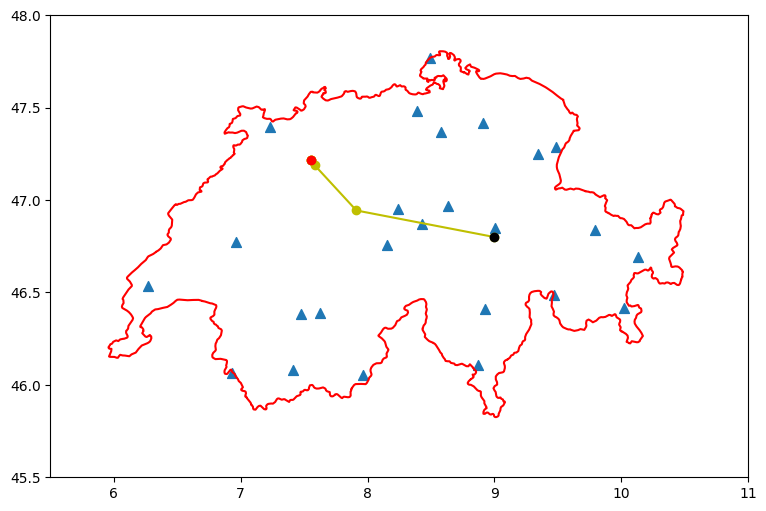

In [20]:
############
#    eloc
#############
pickle_eq = open("../datasets/loctim.pickle","rb") # read in station locations, arrival time data and seismic velocities
[la,lo,el,ts,vp] = pickle.load(pickle_eq)

# la is latitude (Y-coord) of each station in degrees
# lo is longitude (X-coord) of each station in degrees
# el is elevation (Z-coord) of each station in kms
# ts is arrival time of seismic phase at each station in s
# vp is the seismic velocity used for each station in km/s (allows P or S wave data types by choice of velocity)

# load border.xy
pickle_b = open("../datasets/border.pickle","rb") # read in plot border
[borderx,bordery] = pickle.load(pickle_b)

######## Start guess for location
x0=9.     # x or longitude in degrees
y0=46.8   # y or latitude in degrees
z0=-10.   # z in kms

######## locate earthquake
tol = [0.01,0.01] # convergence tolerance for [origin time in s, spatial position in km]

# eqlocate automatically calculates a startng guess for origin time and returns each iteration of the location procedure
sols, res =eq.eqlocate(x0,y0,z0,ts,la,lo,el,vp,tol) #

sol = sols[-1]
tfinal = sols[-1,0] # First parameter is the origin time
xfinal = sols[-1,1] # Second parameter is the Longitude 
yfinal = sols[-1,2] # Third parameter is the Latitude 
zfinal = sols[-1,3] # Fourth parameter is the Depth 

print ('Location', xfinal,yfinal,zfinal)
print ('Event time (seconds after 16:30)',tfinal)

plt.figure(figsize=(9,6))
plt.plot(borderx,bordery,'r-')
plt.scatter(lo,la,s=50,marker='^')
plt.plot(sols[:,1],sols[:,2],'o-y') # solution updates
plt.plot(sols[0,1],sols[0,2],'ok') # initial guess
plt.plot(xfinal,yfinal,'or')
plt.xlim([5.5,11])
plt.ylim([45.5,48])
plt.show()

By default the function `eqlocate()` will fix the depth of an earthquake to the input value provided, unless the option `solvedep=True` is set. This is because Gaussian noise added to arrival times can occaasionally cause the iterative location to diverge in depth, which might could the routine. In calculating many Monte Carlo solutions in this way a subset can also have unrealistic depths, tehreby compromising the exercise.

**Task 2** Now calculate 5000 Monte Carlo solutions by adding Gaussian random noise, $N(0,\sigma^2=0.2s)$ to each arrival time and relocate. Plot the cloud of solutions relative to the original solution.

In [21]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

##############
#    Then use Monte Carlo error propagation to calculate confidence ellipses
##############

######## Start guess for location in degrees
x0=9
y0=46.8
z0=-10

ndata,n,sigma =len(la), 5000, 0.2 # Number of stations, Number of MC solutions, standard deviation of arrival time noise to be added.

MCsols=[]
for i in range(n):
    tsMC= ts +sigma*np.random.randn(ndata)
    sols,res=eq.eqlocate(x0,y0,z0,tsMC,la,lo,el,vp,tol)
    MCsols.append(sols[-1,:])
MCsols=np.array(MCsols)    
sols,res=eq.eqlocate(x0,y0,z0,ts,la,lo,el,vp,tol)

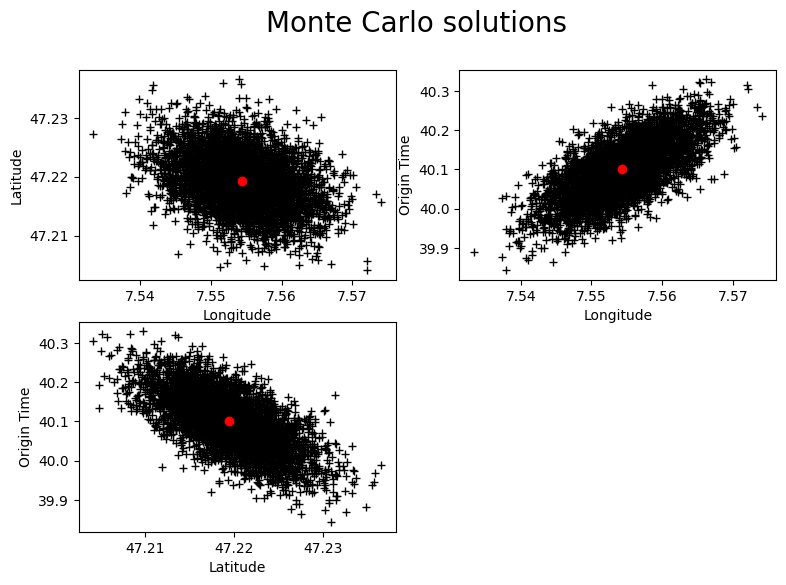

In [22]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

eq.plot_eq_solutions(MCsols,sols)

In [23]:
sols

array([[ 20.11934938,   9.        ,  46.8       , -10.        ],
       [ 48.95038524,   7.91210696,  46.94378561, -10.        ],
       [ 41.21880885,   7.58260267,  47.18910768, -10.        ],
       [ 40.11247758,   7.55464316,  47.21880602, -10.        ],
       [ 40.10010353,   7.55434016,  47.21934548, -10.        ],
       [ 40.10007698,   7.55434045,  47.21934918, -10.        ]])

Now lets plots the same Monte Carlo solutions using a corner plot.

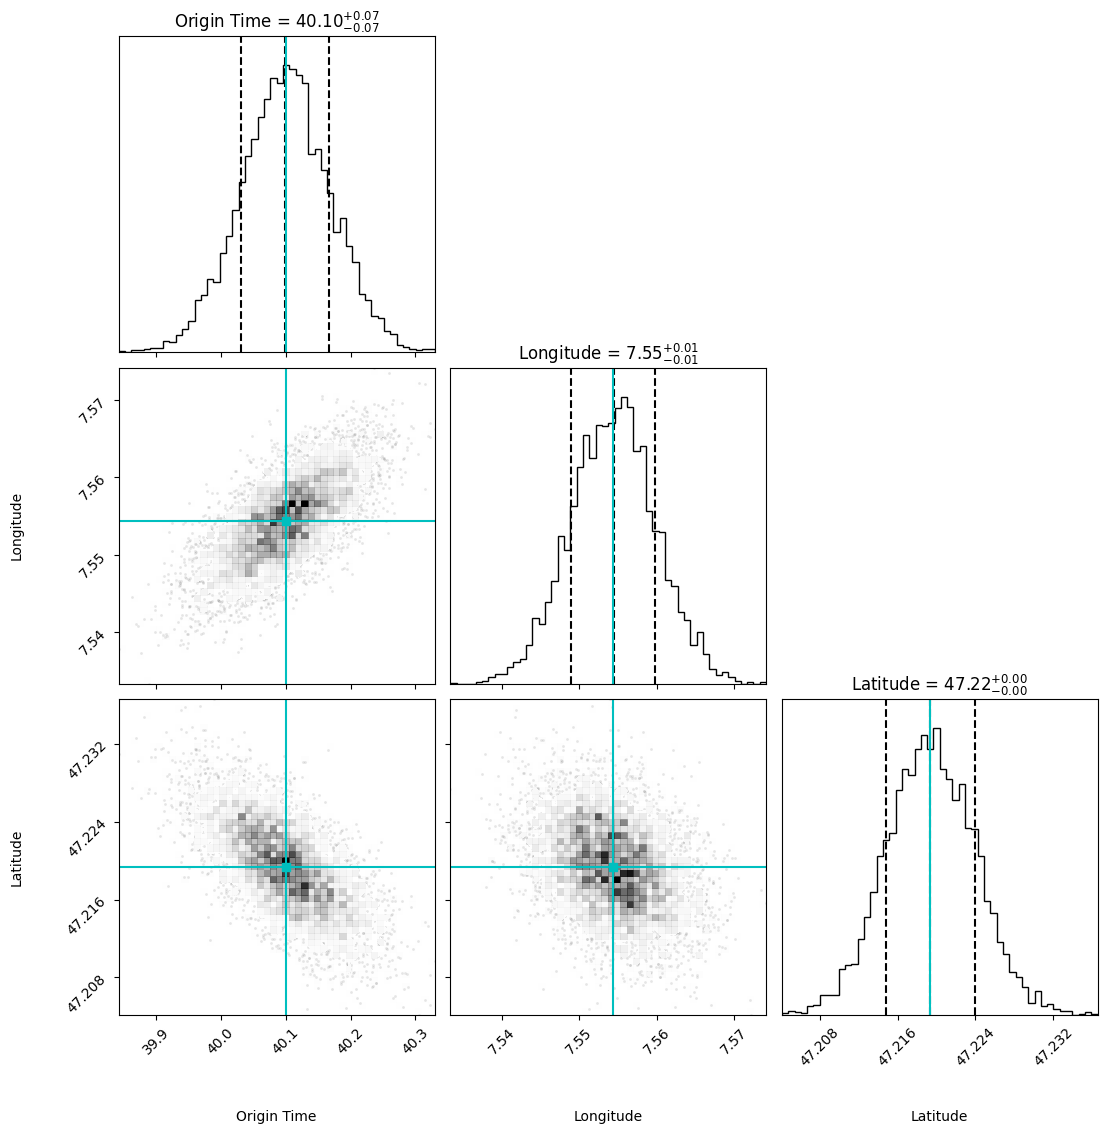

In [24]:
fig = plt.figure(figsize=(12,12))
figure = corner.corner(MCsols[:,:3], labels=['Origin Time','Longitude','Latitude'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},plot_contours=False,bins=50,truths=sols[-1][:3],truth_color='c',fig=fig
)

**Task 3** Now calculate the model covariance matrix from the Monte Carlo solutions, together with the standard deviation and hence the 95% confidence intervals for each parameter,

In [25]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 


###### Calculate covariance solutions numerically from MC solutions.
Cm_cov= np.cov(MCsols.T)
Cm_std= np.std(MCsols,axis=0)
print('Monte Carlo estimate of model covariance matrix\n',Cm_cov)
print('\n Monte Carlo estimate of model standard deviations in each parameter')
print(' Parameter 1: ',Cm_std[0])
print(' Parameter 2: ',Cm_std[1])
print(' Parameter 3: ',Cm_std[2])

sig_param1 = Cm_std[0]
sig_param2 = Cm_std[1]
sig_param3 = Cm_std[2]
print("\n Solution and 95% Confidence intervals ")
print(" Parameter 1 {:7.3f} [{:7.3f}, {:7.3f}]".format(sols[-1][0],sols[-1][0]-1.96*sig_param1,sols[-1][0]+1.96*sig_param1))
print(" Parameter 2 {:7.3f} [{:7.3f}, {:7.3f}]".format(sols[-1][1],sols[-1][1]-1.96*sig_param2,sols[-1][1]+1.96*sig_param2))
print(" Parameter 3 {:7.3f} [{:7.3f}, {:7.3f}]".format(sols[-1][2],sols[-1][2]-1.96*sig_param3,sols[-1][2]+1.96*sig_param3))


Monte Carlo estimate of model covariance matrix
 [[ 4.75815640e-03  2.58998159e-04 -2.09958134e-04  0.00000000e+00]
 [ 2.58998159e-04  2.99860805e-05 -8.68937468e-06  0.00000000e+00]
 [-2.09958134e-04 -8.68937468e-06  2.10449155e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 Monte Carlo estimate of model standard deviations in each parameter
 Parameter 1:  0.0689724928124256
 Parameter 2:  0.005475407135344348
 Parameter 3:  0.004587014988823656

 Solution and 95% Confidence intervals 
 Parameter 1  40.100 [ 39.965,  40.235]
 Parameter 2   7.554 [  7.544,   7.565]
 Parameter 3  47.219 [ 47.210,  47.228]


**Task 4** Now plot the 68% and 95 % confidence ellipses projected onto selected axes relative to the original solution.

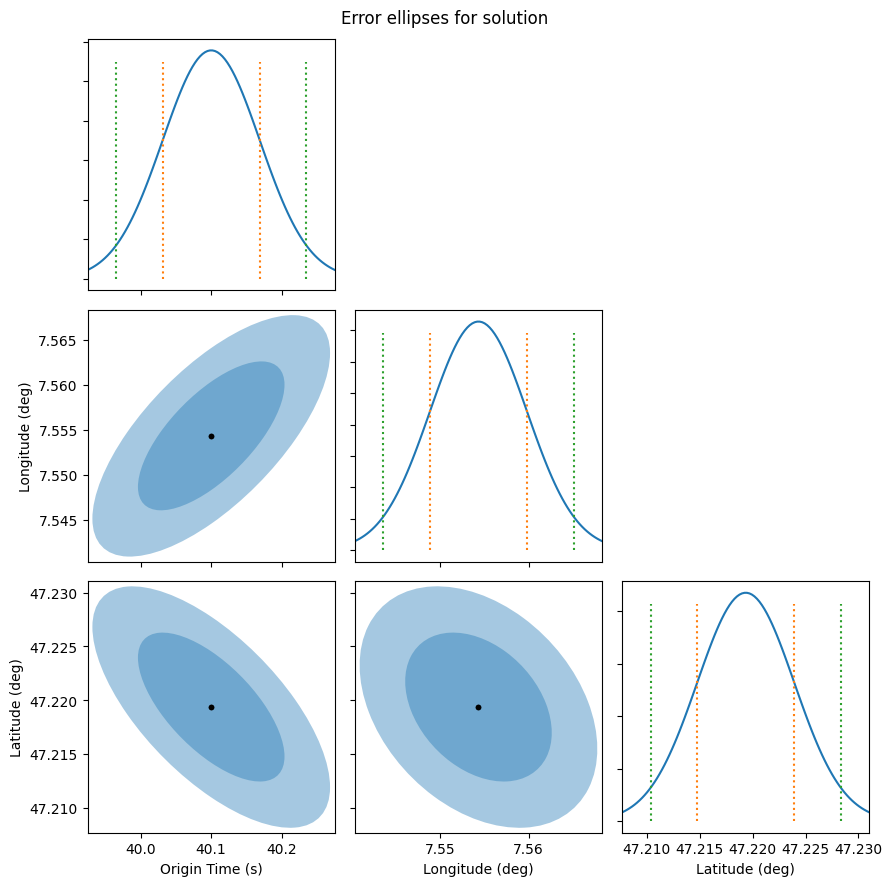

In [26]:
# renove depth from covraiance matrix because it was fixed
Cm = Cm_cov[:3,:3]
mean = sols[-1][:3]
pc.gaussian_corner(Cm,mean,confint=[68,95],title='Error ellipses for solution',labels=['Origin Time (s)','Longitude (deg)','Latitude (deg)'])

----